In [1]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from torch.optim import Adam
import numpy as np
from tqdm.auto import tqdm
import umap
import umap.plot
import pandas as pd
from warnings import filterwarnings

2022-11-05 14:13:28.786770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
fmnist_train = datasets.FashionMNIST(root='Fashion_mnist/',train=True,transform=ToTensor(),download=False)
fmnist_test  = datasets.FashionMNIST(root='Fashion_mnist/',train=False,transform=ToTensor(),download=False)

In [3]:
fmnist_train_loader = DataLoader(dataset=fmnist_train,batch_size=32)
fmnist_test_loader = DataLoader(dataset=fmnist_test,batch_size=32)

In [4]:
filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from helpers import visualize_dataset

In [6]:
batch_idx, (example_data,example_target) = next(enumerate(fmnist_test_loader))

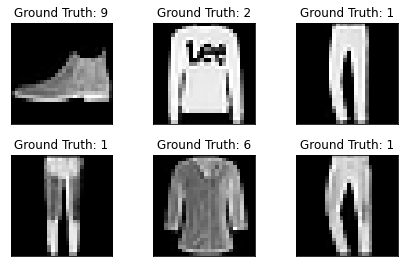

In [7]:
visualize_dataset(example_data=example_data,example_targets=example_target,channel_size=1)

In [8]:
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

In [9]:
class ConditionalVAE(nn.Module):
    
    
    def __init__(self,latent_dim=50):
        
        super(ConditionalVAE,self).__init__()
        
        num_label = 10
        
        self.encoder = nn.Sequential(
            
            nn.Linear(28*28+num_label,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            
        )
        
        self.mu = nn.Linear(256,latent_dim)
        self.sigma = nn.Linear(256,latent_dim)
        
        self.decoder = nn.Sequential(
        
            nn.Linear(latent_dim+num_label,256),
            nn.LeakyReLU(),
            nn.Linear(256,512),
            nn.LeakyReLU(),
            nn.Linear(512, 28*28),
            nn.LeakyReLU()
        )
        
    def reparameterize(self,z_mean,z_log_var):
        
        eps = torch.randn(z_mean.size(0),z_mean.size(1))
        eps = eps.to(device)
        z = z_mean + torch.exp(z_log_var/2) * eps
        
        return z
        
    def forward(self,x,labels):
        
        x = x.view(x.size(0),-1)
        x = torch.cat((x,labels),dim=1)
        x = self.encoder(x)
        
        z_mean, z_log_var = self.mu(x), self.sigma(x)
        z = self.reparameterize(z_mean,z_log_var)
        
        
        x = torch.cat((z,labels),dim=1)
        decoded = self.decoder(x)
        
        return decoded, z_mean, z_log_var
        

In [10]:
def vae_loss(decoded,x,z_mean,z_log_var):
    
    x = x.view(x.size(0),-1)
    recons = F.mse_loss(decoded, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    
    return recons + kl

In [11]:
#model = ConditionalVAE()
#model = model.to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [12]:
def train_conditionalVAE(model,train_loader,loss_fn,optimizer,EPOCH=50):
    
    
    with tqdm(total=len(train_loader)*EPOCH) as tt:
        
        
        for epoch in range(EPOCH):
            
            total_loss = 0
            
            for idx, (batch,target) in enumerate(train_loader):
                
                batch = batch.to(device)
                target = one_hot(target,9)
                target = target.to(device)
                
                decoded, z_mean, z_log_var = model(batch,target)
                
                loss = loss_fn(decoded,batch,z_mean,z_log_var)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
                total_loss += loss.item()
                tt.update()
                
            total_loss = total_loss / idx
            print(f'{total_loss}')

In [13]:
#train_conditionalVAE(model=model,train_loader=fmnist_train_loader,loss_fn=vae_loss,optimizer=optimizer)
cond_vae = torch.load('models/cond_vae.pt',map_location=torch.device('cpu'))

In [14]:
fmnist_test.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [15]:
def generate_cond_images(model,cond=[0,0,0,0,8,8,8,8,1,1,2,2],nsample=12):
    
    rand_features = torch.randn(nsample, 50)
    rand_features = rand_features.to(device)
    
    target_vec = one_hot(cond,9)
    target_vec = target_vec.to(device)
    #print(rand_features.shape)
    #print(target_vec.shape)
    
    z = torch.cat((rand_features,target_vec),dim=1)
    #x = model.linear(z)
    #x = x.view(x.size(0),4,10,10) 
    rand_generated = model.decoder(z)
    
    images = rand_generated.view(nsample,1,28,28)
    images = images.cpu().detach().numpy()
    
    for i in range(12):
            plt.subplot(3,4,i+1)
            plt.tight_layout()
            plt.imshow(images[i][0],cmap='gray')
            plt.xticks([])
            plt.yticks([])
    

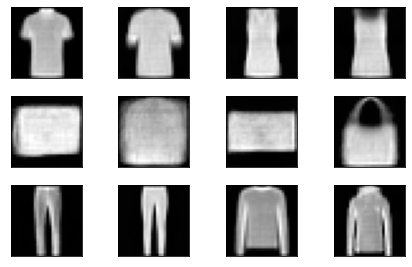

In [16]:
generate_cond_images(model=cond_vae)